## CNN Decision Behaviour Under Image Degradation: A Grad-CAM Analysis

This project presents a controlled computer vision experiment investigating how reduced image quality influences convolutional neural network (CNN) decision behaviour. Using a pretrained ResNet50 model and Grad-CAM, the study examines changes in prediction accuracy, confidence scores, and visual attention patterns under simulated degradation conditions.

### Workflow Overview

1) Load a controlled image dataset (20–30 images).

2) Run baseline inference and generate Grad-CAM visualisations on clean images.

3) Apply Level 1 degradation (moderate downsampling + blur) and re-run inference.

4) Apply Level 2 degradation (heavier downsampling + blur) and re-run inference.

5) Compare accuracy and confidence across clean, Level 1, and Level 2 conditions.

6) Analyse Grad-CAM attention shifts across degradation levels.

7) Summarise behavioural trends and methodological implications.

In [1]:
# Install Grad-CAM and OpenCV for visualisation and image processing
!pip -q install grad-cam opencv-python


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 65.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
# Verify environment and required libraries
import torch
import cv2
from pytorch_grad_cam import GradCAM

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Device:", device)
print("OpenCV:", cv2.__version__)
print("Grad-CAM loaded successfully")


Device: cpu
OpenCV: 4.13.0
Grad-CAM loaded successfully


## 1. Load image dataset
The dataset was extracted from the uploaded archive and organised into fixed cat and dog folders. All images were loaded deterministically (no random sampling), resulting in a balanced subset of 20 cats and 20 dogs (40 total images)

In [16]:
# Unzip dataset, set folder paths, and sample 30 images (15 cats, 15 dogs)

!apt-get -qq install unrar

import os
from pathlib import Path
os.makedirs("figures", exist_ok=True)


RAR_PATH = "/content/PetImages.rar"
EXTRACT_DIR = "/content"

# Extract (force overwrite safely)
!unrar x -o+ -inul {RAR_PATH} {EXTRACT_DIR}

# Now point directly to the inner PetImages folder
DATA_ROOT = Path("/content/PetImages")

CATS_PATH = DATA_ROOT / "cat"
DOGS_PATH = DATA_ROOT / "dog"

IMG_EXTS = {".jpg", ".jpeg", ".png"}

# Safety check
assert CATS_PATH.exists(), f"Missing folder: {CATS_PATH}"
assert DOGS_PATH.exists(), f"Missing folder: {DOGS_PATH}"

# Deterministic ordering
cats = sorted([str(p) for p in CATS_PATH.iterdir() if p.suffix.lower() in IMG_EXTS])
dogs = sorted([str(p) for p in DOGS_PATH.iterdir() if p.suffix.lower() in IMG_EXTS])

selected_images = [(p, 0) for p in cats] + [(p, 1) for p in dogs]

print("Cats:", len(cats))
print("Dogs:", len(dogs))
print("Total:", len(selected_images))




Cats: 20
Dogs: 20
Total: 40


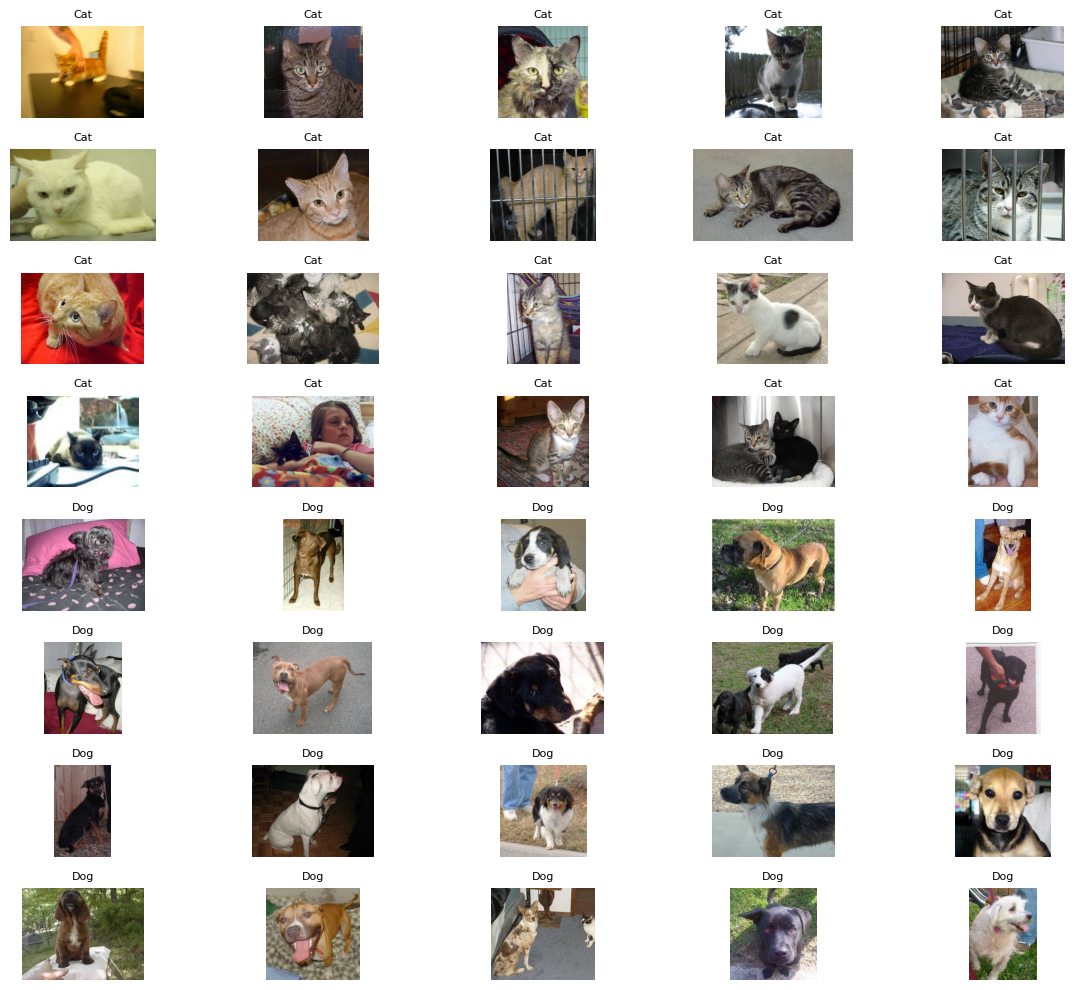

In [17]:
# Visualise selected images (first 15 cats, then 15 dogs)

import matplotlib.pyplot as plt
from PIL import Image

plt.figure(figsize=(12, 10))

for i, (img_path, label) in enumerate(selected_images):
    img = Image.open(img_path).convert("RGB")

    plt.subplot(8, 5, i + 1)
    plt.imshow(img)
    plt.title("Cat" if label == 0 else "Dog", fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.savefig("figures/step1_dataset_grid.png", dpi=300, bbox_inches="tight")
plt.show()



## 2. Load Pretrained ResNet50 and Define Preprocessing (Baseline Inference Setup)
A pretrained ResNet50 (ImageNet) model was loaded in evaluation mode and paired with standard ImageNet preprocessing (224×224 resize, tensor conversion, and mean–std normalisation). This ensures consistency with the model’s original training distribution and allows fair comparison across clean and degraded inputs.

Results on the fixed 40-image CLEAN dataset:

* Accuracy (Clean): 0.975 (39/40 correct)
* Mean Absolute Binary Confidence: 0.464 (Probability mass assigned to Cat/Dog within the full 1000-class ImageNet space)
* Mean Superclass Mass (Cat + Dog): 0.507
(~50% of total probability mass is allocated to cat/dog classes)
* Mean Renormalised Binary Confidence: 0.89 (Model confidence conditioned only on Cat vs Dog)

This distinction is important: although absolute confidence appears moderate due to probability mass distributed across unrelated ImageNet classes, the renormalised confidence shows strong binary discrimination under clean conditions.

Grad-CAM visualisations demonstrate that attention is primarily concentrated on semantically meaningful regions (e.g., face, head, body contours), indicating behaviourally coherent decision-making in the baseline condition.

In [5]:
# Step 2: Load pretrained ResNet50 and define ImageNet preprocessing

import torchvision.transforms as T
from torchvision import models

# Load pretrained ResNet50 (ImageNet weights)
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model.eval()
model = model.to(device)

# Standard ImageNet preprocessing
preprocess = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

print("Model: ResNet50 (ImageNet pretrained)")
print("Device:", device)


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 191MB/s]


Model: ResNet50 (ImageNet pretrained)
Device: cpu


In [6]:
# Step 2.1: Clean inference with correct ImageNet cat/dog summed-prob mapping
# Reports BOTH:
#  (1) Absolute binary confidence: max(cat_prob, dog_prob)
#  (2) Renormalised binary confidence: max(cat_prob, dog_prob) / (cat_prob + dog_prob)

import torch
import torch.nn.functional as F
from PIL import Image

# ImageNet index ranges (inclusive)
DOG_IDX = list(range(151, 269))   # 151–268
CAT_IDX = list(range(281, 286))   # 281–285

dog_idx = torch.tensor(DOG_IDX, device=device)
cat_idx = torch.tensor(CAT_IDX, device=device)

correct = 0
results_clean = []  # (path, true, pred, cat_prob, dog_prob, abs_conf, mass, renorm_conf)

for img_path, true_label in selected_images:
    image = Image.open(img_path).convert("RGB")
    x = preprocess(image).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(x)
        probs = F.softmax(logits, dim=1).squeeze(0)  # [1000]

        dog_prob = probs.index_select(0, dog_idx).sum()
        cat_prob = probs.index_select(0, cat_idx).sum()

    dog_prob_f = float(dog_prob.item())
    cat_prob_f = float(cat_prob.item())

    # Binary prediction (0=cat, 1=dog)
    pred_label = 1 if dog_prob_f >= cat_prob_f else 0

    # Absolute metrics (in 1000-class probability space)
    abs_conf = max(dog_prob_f, cat_prob_f)
    mass = dog_prob_f + cat_prob_f

    # Renormalised metrics (conditional on Cat vs Dog only)
    renorm_conf = abs_conf / mass if mass > 0 else 0.0

    correct += int(pred_label == true_label)

    results_clean.append((img_path, true_label, pred_label,
                          cat_prob_f, dog_prob_f, abs_conf, mass, renorm_conf))

accuracy_clean = correct / len(selected_images)
mean_abs_conf_clean = sum(r[5] for r in results_clean) / len(results_clean)
mean_mass_clean = sum(r[6] for r in results_clean) / len(results_clean)
mean_renorm_conf_clean = sum(r[7] for r in results_clean) / len(results_clean)

print("Accuracy (Clean):", round(accuracy_clean, 3))
print("Mean Absolute Binary Confidence (Clean):", round(mean_abs_conf_clean, 3))
print("Mean (cat_prob + dog_prob) Mass (Clean):", round(mean_mass_clean, 3))
print("Mean Renormalised Binary Confidence (Clean):", round(mean_renorm_conf_clean, 3))


Accuracy (Clean): 0.975
Mean Absolute Binary Confidence (Clean): 0.464
Mean (cat_prob + dog_prob) Mass (Clean): 0.507
Mean Renormalised Binary Confidence (Clean): 0.89


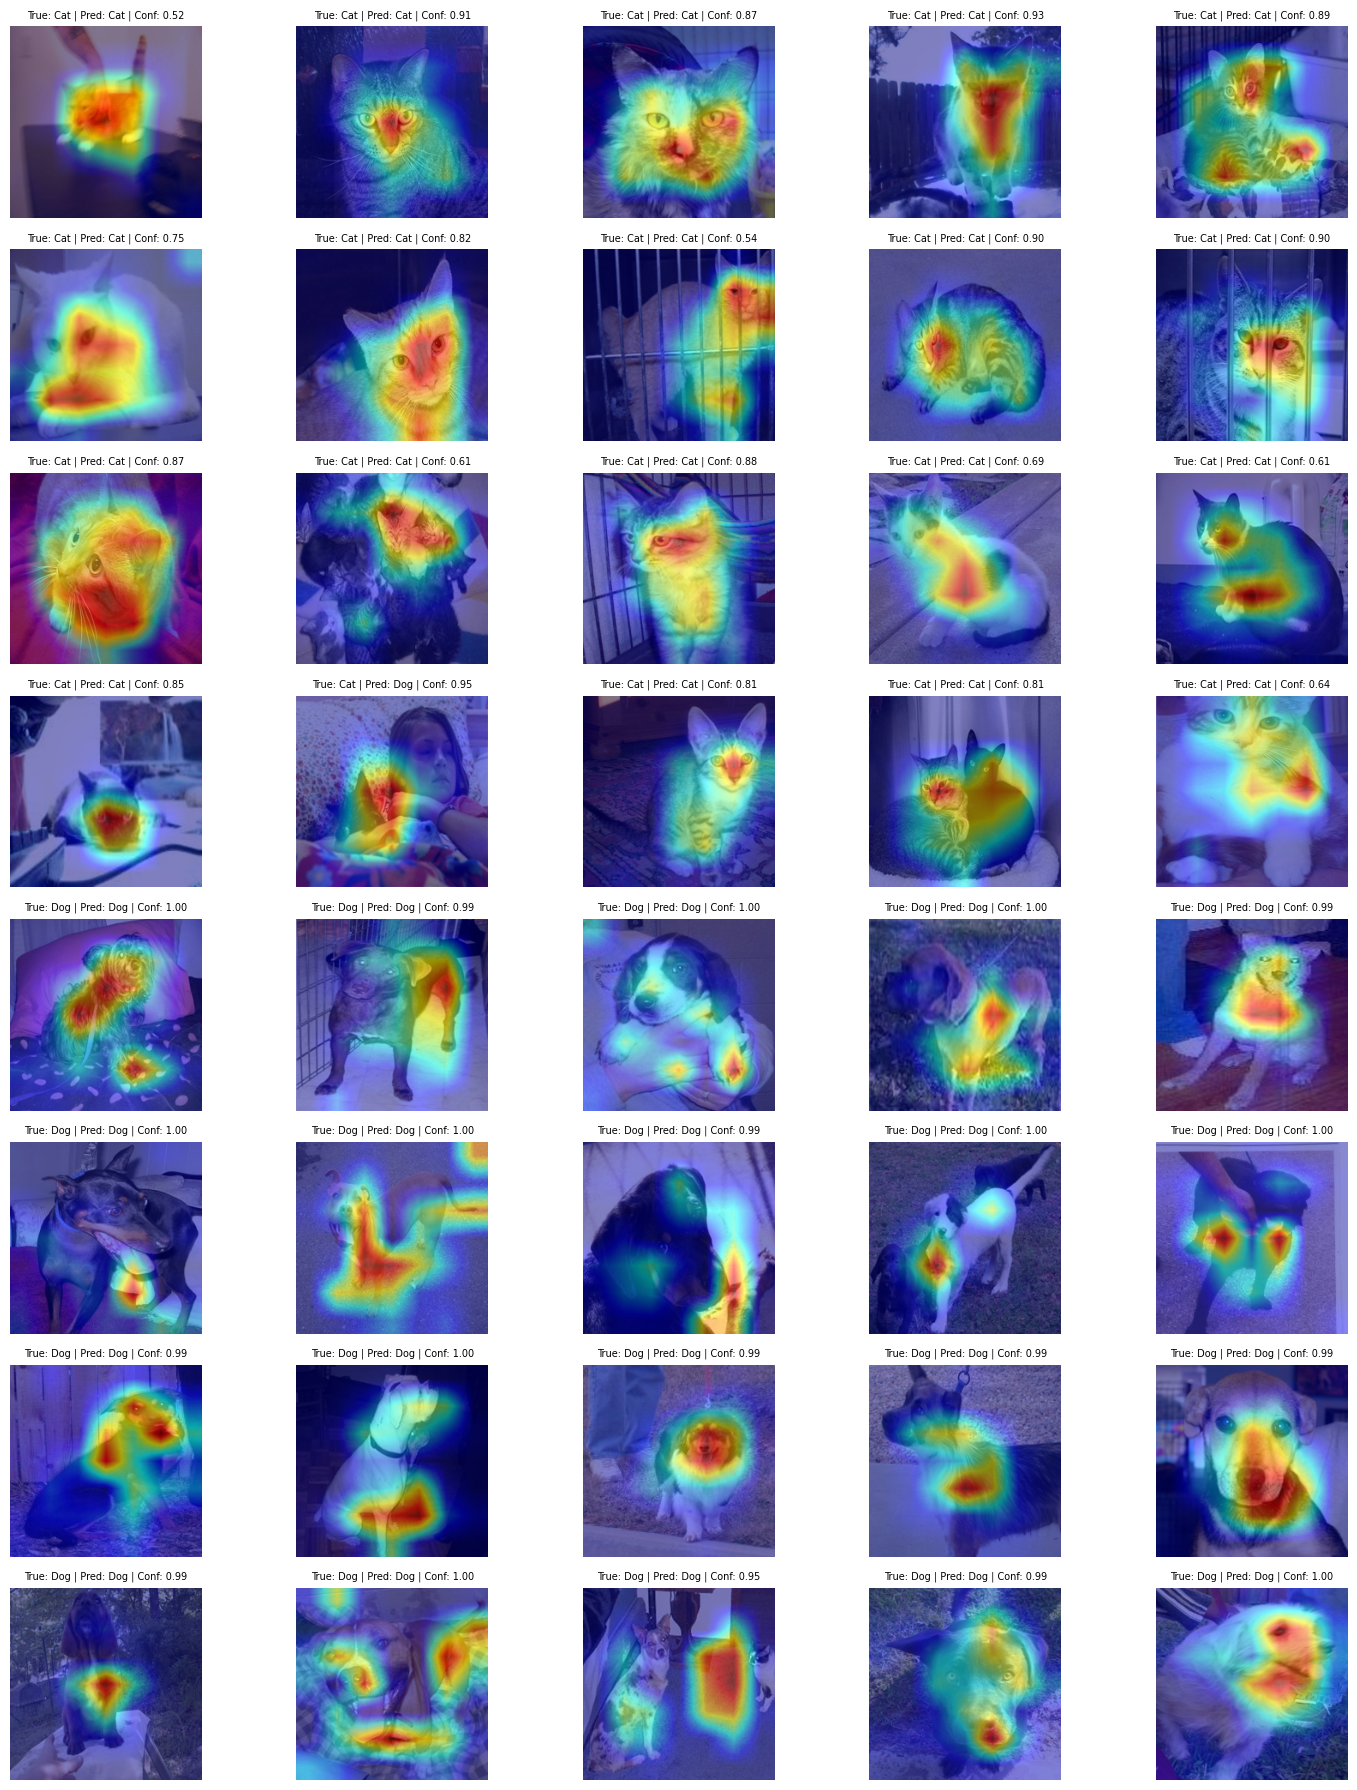

In [18]:
# Step 2.2: Grad-CAM visualisation for CLEAN images
# Display: True | Pred | Confidence (renormalised binary confidence)

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

# ImageNet index ranges
DOG_IDX = list(range(151, 269))
CAT_IDX = list(range(281, 286))

dog_idx = torch.tensor(DOG_IDX, device=device)
cat_idx = torch.tensor(CAT_IDX, device=device)

class SumLogitsTarget:
    def __init__(self, idx_tensor: torch.Tensor):
        self.idx_tensor = idx_tensor

    def __call__(self, model_output: torch.Tensor) -> torch.Tensor:
        if model_output.dim() == 1:
            model_output = model_output.unsqueeze(0)
        return model_output[:, self.idx_tensor].sum(dim=1)

target_layers = [model.layer4[-1]]
cam = GradCAM(model=model, target_layers=target_layers)

plt.figure(figsize=(15, 18))

for i, (img_path, true_label, pred_label, cat_prob, dog_prob,
        abs_conf, mass, renorm_conf) in enumerate(results_clean):

    image = Image.open(img_path).convert("RGB")
    input_tensor = preprocess(image).unsqueeze(0).to(device)

    target = SumLogitsTarget(dog_idx if pred_label == 1 else cat_idx)
    grayscale_cam = cam(input_tensor=input_tensor, targets=[target])[0]

    rgb_img = np.array(image.resize((224, 224))) / 255.0
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    plt.subplot(8, 5, i + 1)
    plt.imshow(visualization)

    plt.title(
        f"True: {'Cat' if true_label==0 else 'Dog'} | "
        f"Pred: {'Dog' if pred_label==1 else 'Cat'} | "
        f"Conf: {renorm_conf:.2f}",
        fontsize=7
    )

    plt.axis("off")

plt.tight_layout()
plt.savefig("figures/step2_clean_gradcam_grid.png", dpi=300, bbox_inches="tight")
plt.show()



## 3.  Apply Level 1 degradation (moderate downsampling and blur) and re-run inference.
Level 1 degradation was applied by downsampling each image to 112×112, upsampling back to 224×224, and applying Gaussian blur. This simulates moderate resolution loss and visual smoothing while preserving overall structure.

All 40 images were successfully degraded and re-evaluated using the same binary summed-probability inference framework.

Results (Level 1):

* Accuracy: 0.900 (drop from 0.975 clean)
* Mean Absolute Binary Confidence: 0.447 (slight reduction)
* Mean Cat/Dog Probability Mass: 0.488 (more probability allocated to unrelated ImageNet classes)
* Mean Renormalised Binary Confidence: 0.886 (highly stable)

These results indicate that moderate degradation reduces classification accuracy and overall certainty in the cat/dog superclass.However, the model’s relative discrimination between Cat and Dog remains strong when conditioned only on the two classes.

This suggests mild sensitivity to reduced resolution and blur, while maintaining robust binary separation under moderate degradation.


In [8]:
# Step 3: Level 1 degradation (downsample to 112x112; upsample to 224x224 plus Gaussian blur)

import cv2
import numpy as np

level1_images = []  # (img_path, degraded_rgb_uint8, true_label)

for img_path, true_label in selected_images:
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Downsample then upsample
    small = cv2.resize(img, (112, 112), interpolation=cv2.INTER_AREA)
    upsampled = cv2.resize(small, (224, 224), interpolation=cv2.INTER_LINEAR)

    # Blur
    blurred = cv2.GaussianBlur(upsampled, (7, 7), 0)

    level1_images.append((img_path, blurred, true_label))

print("Total Level 1 images:", len(level1_images))



Total Level 1 images: 40


#### Re-run inference on Level 1 degraded images.
To evaluate how image degradation affects model performance by computing accuracy and confidence on the degraded images.



In [9]:
# Step 3.1: Level 1 inference with correct summed-prob cat/dog mapping (reports both confidences)

import torch
import torch.nn.functional as F
from PIL import Image

DOG_IDX = list(range(151, 269))
CAT_IDX = list(range(281, 286))

dog_idx = torch.tensor(DOG_IDX, device=device)
cat_idx = torch.tensor(CAT_IDX, device=device)

correct_l1 = 0
results_l1 = []  # (img_path, true, pred, cat_prob, dog_prob, abs_conf, mass, renorm_conf)

for img_path, image_array, true_label in level1_images:
    image = Image.fromarray(image_array).convert("RGB")
    x = preprocess(image).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(x)
        probs = F.softmax(logits, dim=1).squeeze(0)

        dog_prob = probs.index_select(0, dog_idx).sum()
        cat_prob = probs.index_select(0, cat_idx).sum()

    dog_prob_f = float(dog_prob.item())
    cat_prob_f = float(cat_prob.item())

    pred_label = 1 if dog_prob_f >= cat_prob_f else 0

    abs_conf = max(dog_prob_f, cat_prob_f)
    mass = dog_prob_f + cat_prob_f
    renorm_conf = abs_conf / mass if mass > 0 else 0.0

    correct_l1 += int(pred_label == true_label)

    results_l1.append((img_path, true_label, pred_label,
                       cat_prob_f, dog_prob_f, abs_conf, mass, renorm_conf))

accuracy_l1 = correct_l1 / len(level1_images)
mean_abs_conf_l1 = sum(r[5] for r in results_l1) / len(results_l1)
mean_mass_l1 = sum(r[6] for r in results_l1) / len(results_l1)
mean_renorm_conf_l1 = sum(r[7] for r in results_l1) / len(results_l1)

print("Accuracy (Level 1):", round(accuracy_l1, 3))
print("Mean Absolute Binary Confidence (Level 1):", round(mean_abs_conf_l1, 3))
print("Mean (cat_prob + dog_prob) Mass (Level 1):", round(mean_mass_l1, 3))
print("Mean Renormalised Binary Confidence (Level 1):", round(mean_renorm_conf_l1, 3))


Accuracy (Level 1): 0.9
Mean Absolute Binary Confidence (Level 1): 0.447
Mean (cat_prob + dog_prob) Mass (Level 1): 0.488
Mean Renormalised Binary Confidence (Level 1): 0.886


## 4. Apply Level 2 degradation (heavier downsampling and blur) and re-run inference.
Level 2 degradation introduced stronger visual distortion by downsampling each image to 64×64, upsampling back to 224×224, and applying a heavier Gaussian blur. This simulates substantial resolution loss and structural smoothing while preserving coarse object shape.

All 40 images were re-evaluated using the same summed-probability binary inference framework.

Results (Level 2):

* Accuracy: 0.775 (further drop from 0.900 Level 1 and 0.975 clean)
* Mean Absolute Binary Confidence: 0.420 (continued decline)
* Mean Cat/Dog Probability Mass: 0.462 (more probability shifts to unrelated ImageNet classes)
* Mean Renormalised Binary Confidence: ~0.89 (stable relative discrimination)

These results show that stronger degradation significantly reduces classification accuracy and overall certainty within the full 1000-class space. However, when conditioned solely on the Cat vs Dog decision, the model remains highly decisive.

This indicates that degradation primarily affects global certainty and class allocation across ImageNet, while relative binary separation between Cat and Dog remains comparatively robust..

In [10]:
# Step 4: Level 2 degradation (stronger downsample and stronger blur)

import cv2
import numpy as np

level2_images = []  # (img_path, degraded_rgb_uint8, true_label)

for img_path, true_label in selected_images:

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Stronger downsample
    small = cv2.resize(img, (64, 64), interpolation=cv2.INTER_AREA)
    upsampled = cv2.resize(small, (224, 224), interpolation=cv2.INTER_LINEAR)

    # Stronger blur
    blurred = cv2.GaussianBlur(upsampled, (15, 15), 0)

    level2_images.append((img_path, blurred, true_label))

print("Total Level 2 images:", len(level2_images))



Total Level 2 images: 40


#### Run Inference on Level 2 Degraded Images
We run the same ResNet50 evaluation on Level 2 degraded images to measure performance under stronger quality loss.

In [11]:
# Step 4.1: Level 2 inference with correct summed-prob cat/dog mapping (reports both confidences)

import torch
import torch.nn.functional as F
from PIL import Image

DOG_IDX = list(range(151, 269))
CAT_IDX = list(range(281, 286))

dog_idx = torch.tensor(DOG_IDX, device=device)
cat_idx = torch.tensor(CAT_IDX, device=device)

correct_l2 = 0
results_l2 = []  # (img_path, true, pred, cat_prob, dog_prob, abs_conf, mass, renorm_conf)

for img_path, image_array, true_label in level2_images:
    image = Image.fromarray(image_array).convert("RGB")
    x = preprocess(image).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(x)
        probs = F.softmax(logits, dim=1).squeeze(0)

        dog_prob = probs.index_select(0, dog_idx).sum()
        cat_prob = probs.index_select(0, cat_idx).sum()

    dog_prob_f = float(dog_prob.item())
    cat_prob_f = float(cat_prob.item())

    pred_label = 1 if dog_prob_f >= cat_prob_f else 0

    abs_conf = max(dog_prob_f, cat_prob_f)
    mass = dog_prob_f + cat_prob_f
    renorm_conf = abs_conf / mass if mass > 0 else 0.0

    correct_l2 += int(pred_label == true_label)

    results_l2.append((img_path, true_label, pred_label,
                       cat_prob_f, dog_prob_f, abs_conf, mass, renorm_conf))

accuracy_l2 = correct_l2 / len(level2_images)
mean_abs_conf_l2 = sum(r[5] for r in results_l2) / len(results_l2)
mean_mass_l2 = sum(r[6] for r in results_l2) / len(results_l2)
mean_renorm_conf_l2 = sum(r[7] for r in results_l2) / len(results_l2)

print("Accuracy (Level 2):", round(accuracy_l2, 3))
print("Mean Absolute Binary Confidence (Level 2):", round(mean_abs_conf_l2, 3))
print("Mean (cat_prob + dog_prob) Mass (Level 2):", round(mean_mass_l2, 3))
print("Mean Renormalised Binary Confidence (Level 2):", round(mean_renorm_conf_l2, 3))


Accuracy (Level 2): 0.775
Mean Absolute Binary Confidence (Level 2): 0.42
Mean (cat_prob + dog_prob) Mass (Level 2): 0.462
Mean Renormalised Binary Confidence (Level 2): 0.89


## 5. Compare Accuracy and Confidence Across Conditions



In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Extract metrics from the results

# Absolute confidence
abs_clean = [r[5] for r in results_clean]
abs_l1    = [r[5] for r in results_l1]
abs_l2    = [r[5] for r in results_l2]

# Renormalised confidence
renorm_clean = [r[7] for r in results_clean]
renorm_l1    = [r[7] for r in results_l1]
renorm_l2    = [r[7] for r in results_l2]

# Compute means
mean_abs_clean = np.mean(abs_clean)
mean_abs_l1    = np.mean(abs_l1)
mean_abs_l2    = np.mean(abs_l2)

mean_renorm_clean = np.mean(renorm_clean)
mean_renorm_l1    = np.mean(renorm_l1)
mean_renorm_l2    = np.mean(renorm_l2)

print("=== Accuracy ===")
print("Clean:", round(accuracy_clean,3))
print("Level 1:", round(accuracy_l1,3))
print("Level 2:", round(accuracy_l2,3))

print("\n=== Mean Absolute Binary Confidence ===")
print("Clean:", round(mean_abs_clean,3))
print("Level 1:", round(mean_abs_l1,3))
print("Level 2:", round(mean_abs_l2,3))

print("\n=== Mean Renormalised Binary Confidence ===")
print("Clean:", round(mean_renorm_clean,3))
print("Level 1:", round(mean_renorm_l1,3))
print("Level 2:", round(mean_renorm_l2,3))


=== Accuracy ===
Clean: 0.975
Level 1: 0.9
Level 2: 0.775

=== Mean Absolute Binary Confidence ===
Clean: 0.464
Level 1: 0.447
Level 2: 0.42

=== Mean Renormalised Binary Confidence ===
Clean: 0.89
Level 1: 0.886
Level 2: 0.89


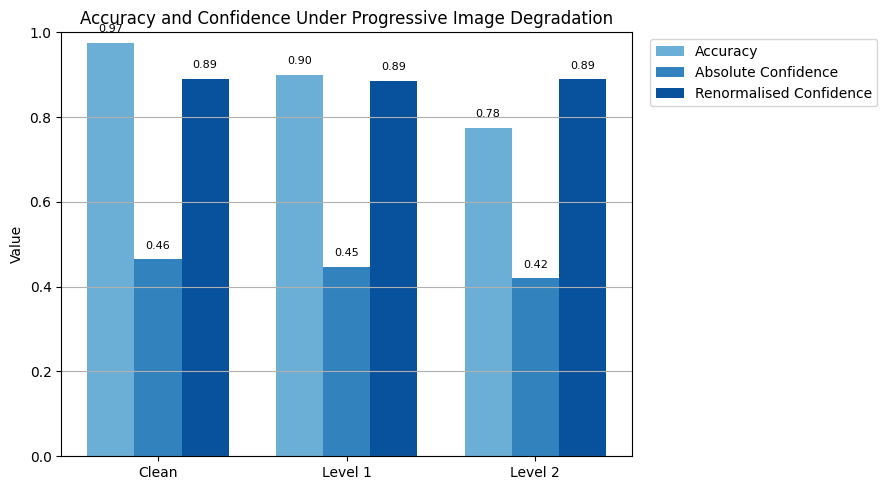

In [19]:
# Grouped Bar Chart: Accuracy and Confidence Across Degradation Levels

import numpy as np
import matplotlib.pyplot as plt

conditions = ["Clean", "Level 1", "Level 2"]
x = np.arange(len(conditions))
w = 0.25

accuracy_values = [accuracy_clean, accuracy_l1, accuracy_l2]
abs_conf_values = [
    np.mean([r[5] for r in results_clean]),
    np.mean([r[5] for r in results_l1]),
    np.mean([r[5] for r in results_l2]),
]
renorm_conf_values = [
    np.mean([r[7] for r in results_clean]),
    np.mean([r[7] for r in results_l1]),
    np.mean([r[7] for r in results_l2]),
]

fig, ax = plt.subplots(figsize=(9, 5))

# Blue shades: light -> darker -> darkest
bars1 = ax.bar(x - w, accuracy_values, width=w, label="Accuracy", color="#6BAED6")
bars2 = ax.bar(x,     abs_conf_values, width=w, label="Absolute Confidence", color="#3182BD")
bars3 = ax.bar(x + w, renorm_conf_values, width=w, label="Renormalised Confidence", color="#08519C")

ax.set_xticks(x)
ax.set_xticklabels(conditions)
ax.set_ylim(0, 1)
ax.set_ylabel("Value")
ax.set_title("Accuracy and Confidence Under Progressive Image Degradation")

# Legend outside
ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left")

# Numbers on bars
def add_labels(bars):
    for b in bars:
        h = b.get_height()
        ax.text(b.get_x() + b.get_width()/2, h + 0.02, f"{h:.2f}",
                ha="center", va="bottom", fontsize=8)

add_labels(bars1); add_labels(bars2); add_labels(bars3)

ax.grid(True, axis="y")
plt.tight_layout()
plt.savefig("figures/step5_grouped_bar_chart.png", dpi=300, bbox_inches="tight")
plt.show()




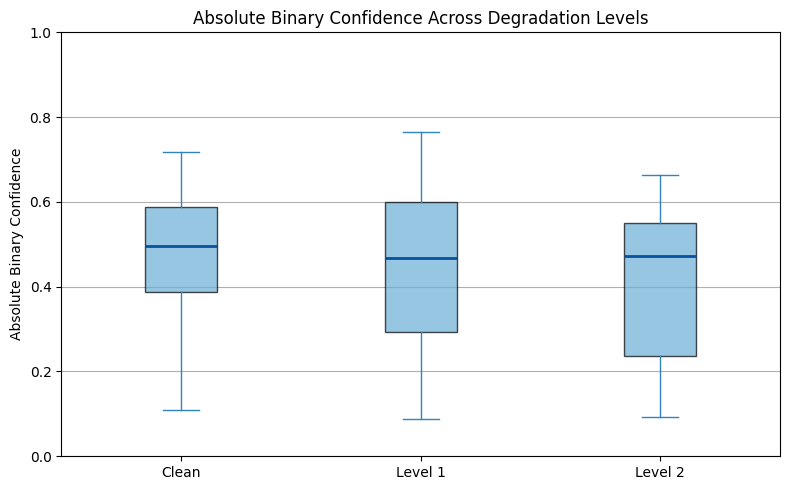

In [20]:
# Boxplot: Absolute Binary Confidence Across Degradation Levels

import matplotlib.pyplot as plt

abs_clean = [r[5] for r in results_clean]
abs_l1    = [r[5] for r in results_l1]
abs_l2    = [r[5] for r in results_l2]

data = [abs_clean, abs_l1, abs_l2]

fig, ax = plt.subplots(figsize=(8, 5))

box = ax.boxplot(
    data,
    patch_artist=True,
    tick_labels=["Clean", "Level 1", "Level 2"]
)

# Blue styling
for patch in box['boxes']:
    patch.set_facecolor("#6BAED6")
    patch.set_alpha(0.7)

for median in box['medians']:
    median.set_color("#08519C")
    median.set_linewidth(2)

for whisker in box['whiskers']:
    whisker.set_color("#3182BD")

for cap in box['caps']:
    cap.set_color("#3182BD")

for flier in box['fliers']:
    flier.set(marker='o', color="#08519C", alpha=0.5)

ax.set_ylim(0, 1)
ax.set_ylabel("Absolute Binary Confidence")
ax.set_title("Absolute Binary Confidence Across Degradation Levels")

ax.grid(True, axis="y")
plt.tight_layout()
plt.savefig("figures/step5_abs_conf_boxplot.png", dpi=300, bbox_inches="tight")
plt.show()



## 6. Grad-CAM attention shift across degradation levels
Generate side-by-side Grad-CAM overlays for each image (3 cats and 3 dogs) under Clean, Level 1, and Level 2 to observe attention drift as quality reduces.

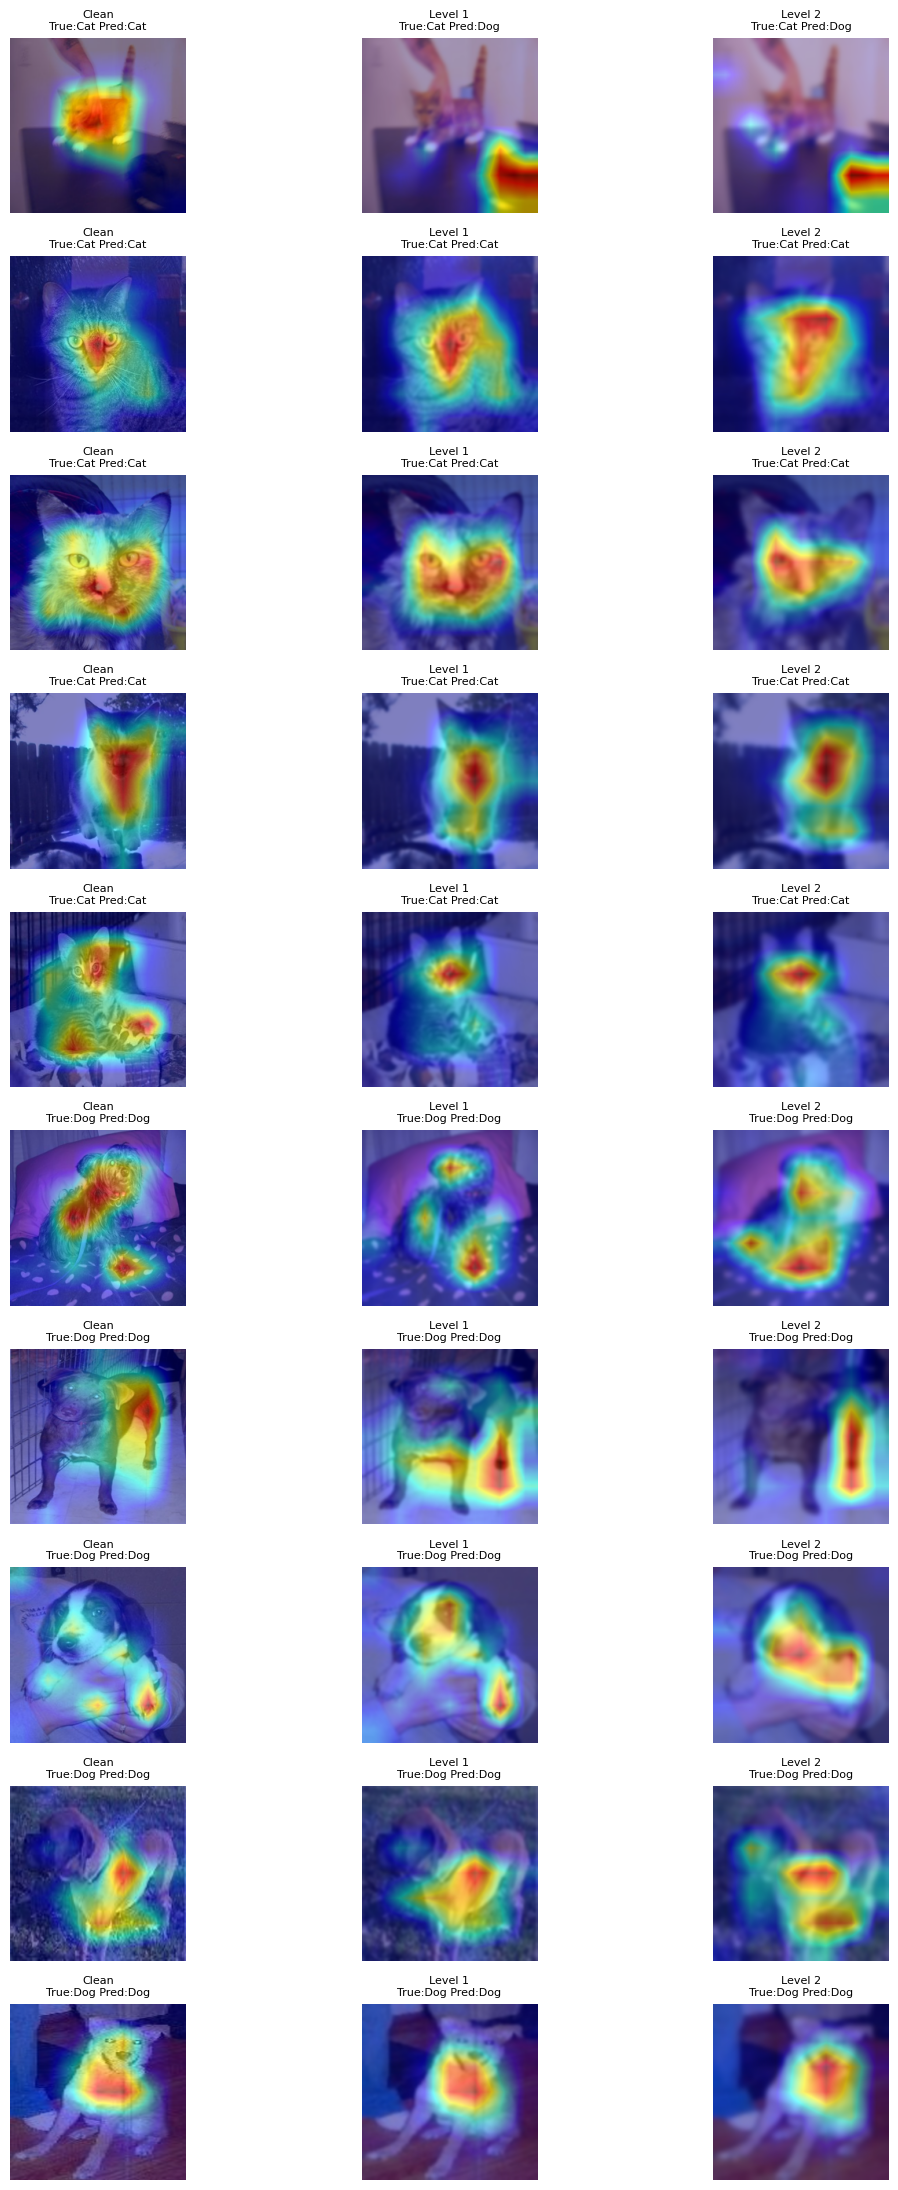

In [23]:
# Step 6: Grad-CAM attention shift (Clean vs Level 1 vs Level 2) — True/Pred only

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

DOG_IDX = list(range(151, 269))
CAT_IDX = list(range(281, 286))
dog_idx = torch.tensor(DOG_IDX, device=device)
cat_idx = torch.tensor(CAT_IDX, device=device)

class SumLogitsTarget:
    def __init__(self, idx_tensor: torch.Tensor):
        self.idx_tensor = idx_tensor
    def __call__(self, model_output: torch.Tensor) -> torch.Tensor:
        if model_output.dim() == 1:
            model_output = model_output.unsqueeze(0)
        return model_output[:, self.idx_tensor].sum(dim=1)

target_layers = [model.layer4[-1]]
cam = GradCAM(model=model, target_layers=target_layers)

def infer_pred(pil_img):
    x = preprocess(pil_img).unsqueeze(0).to(device)
    with torch.no_grad():
        probs = torch.softmax(model(x), dim=1).squeeze(0)
        dog_p = probs.index_select(0, dog_idx).sum().item()
        cat_p = probs.index_select(0, cat_idx).sum().item()
    return 1 if dog_p >= cat_p else 0  # 1=dog, 0=cat

def cam_overlay(pil_img, pred_label):
    x = preprocess(pil_img).unsqueeze(0).to(device)
    target = SumLogitsTarget(dog_idx if pred_label == 1 else cat_idx)
    grayscale = cam(input_tensor=x, targets=[target])[0]
    rgb = np.array(pil_img.resize((224, 224))) / 255.0
    return show_cam_on_image(rgb, grayscale, use_rgb=True)

def plot_triplets(indices, figsize=(12, 22), fontsize=8):
    plt.figure(figsize=figsize)

    for r, idx in enumerate(indices):
        img_path, true_label = selected_images[idx]
        true_txt = "Cat" if true_label == 0 else "Dog"
        pred_txt = lambda p: ("Dog" if p == 1 else "Cat")

        clean_img = Image.open(img_path).convert("RGB")

        _, l1_arr, _ = level1_images[idx]
        _, l2_arr, _ = level2_images[idx]
        l1_img = Image.fromarray(l1_arr).convert("RGB")
        l2_img = Image.fromarray(l2_arr).convert("RGB")

        pred_c = infer_pred(clean_img)
        pred_1 = infer_pred(l1_img)
        pred_2 = infer_pred(l2_img)

        vis_c = cam_overlay(clean_img, pred_c)
        vis_1 = cam_overlay(l1_img, pred_1)
        vis_2 = cam_overlay(l2_img, pred_2)

        # Clean
        plt.subplot(len(indices), 3, 3*r + 1)
        plt.imshow(vis_c); plt.axis("off")
        plt.title(f"Clean\nTrue:{true_txt} Pred:{pred_txt(pred_c)}", fontsize=fontsize)

        # Level 1
        plt.subplot(len(indices), 3, 3*r + 2)
        plt.imshow(vis_1); plt.axis("off")
        plt.title(f"Level 1\nTrue:{true_txt} Pred:{pred_txt(pred_1)}", fontsize=fontsize)

        # Level 2
        plt.subplot(len(indices), 3, 3*r + 3)
        plt.imshow(vis_2); plt.axis("off")
        plt.title(f"Level 2\nTrue:{true_txt} Pred:{pred_txt(pred_2)}", fontsize=fontsize)

    plt.tight_layout()
    plt.savefig("figures/step6_gradcam_triplets_10.png", dpi=300, bbox_inches="tight")
    plt.show()


# Main: 10 examples (5 cats + 5 dogs)
indices_10 = [0, 1, 2, 3, 4, 20, 21, 22, 23, 24]
plot_triplets(indices_10)


In [24]:
!zip -r figures.zip figures


  adding: figures/ (stored 0%)
  adding: figures/step6_gradcam_triplets_10.png (deflated 1%)
  adding: figures/.ipynb_checkpoints/ (stored 0%)
  adding: figures/step1_dataset_grid.png (deflated 1%)
  adding: figures/step5_abs_conf_boxplot.png (deflated 26%)
  adding: figures/step2_clean_gradcam_grid.png (deflated 0%)
  adding: figures/step5_grouped_bar_chart.png (deflated 24%)


## Step 7: Summary behavioural trends and methodological implications
This project examined how a pretrained ResNet50 behaves when image quality is progressively reduced. Using a fixed set of 40 Cat and Dog images, the model was evaluated under three conditions: Clean, Level 1 degradation, and Level 2 degradation.

#### Methodology (What was done):
* Used ResNet50 with standard ImageNet preprocessing for consistent inference.

* Defined binary probabilities as:
  * dog_prob = Σ softmax(151–268);
  * cat_prob = Σ softmax(281–285)
* Reported two confidence views:
  * Absolute binary confidence = max(cat_prob, dog_prob) (in full 1000-class space)
  * Renormalised confidence = max(cat_prob, dog_prob) / (cat_prob + dog_prob) (Cat vs Dog only)


* Applied controlled degradations:
   * Level 1: 112×112 downsample to 224×224 upsample and moderate Gaussian blur
   * Level 2: 64×64 downsample to 224×224 upsample abd stronger Gaussian blur

#### Quantitative Results (Behaviour under degradation)

* Accuracy: 0.975 to 0.900 to 0.775
(progressive degradation causes clear performance drop)
* Mean Absolute Binary Confidence: 0.464 to 0.447 to 0.420
(overall certainty reduces as quality decreases)
* Mean Cat/Dog Probability Mass: 0.507 to 0.488 to 0.462
(more probability shifts to non-cat/dog ImageNet classes under degradation)
* Mean Renormalised Confidence: 0.890 to 0.886 to 0.890
(binary decisiveness remains stable when conditioned only on Cat vs Dog)

The boxplot of absolute confidence reinforces this trend. It shows a visible downward shift in the distribution under increasing degradation, with greater spread in Level 2. This indicates that degradation does not affect all images equally, some samples remain stable while others experience sharper confidence drops.

Key interpretation: degradation reduces correctness and global certainty, but the model remains strongly decisive between cat vs dog once it commits to that binary framing.

#### Qualitative Results (Grad-CAM attention shift)

Side-by-side Grad-CAM comparisons (Clean vs Level 1 vs Level 2) show a consistent attention pattern:

* Clean: attention tends to focus on semantically meaningful regions (faces, head, body contours).
* Level 1: attention becomes broader/coarser and sometimes shifts partially off-target.
* Level 2: attention often becomes diffuse or drifts to background/high-contrast regions, coinciding with increased misclassifications.

This supports the quantitative results: as image detail is removed, the model increasingly relies on coarse textures and spurious cues rather than stable semantic features.

#### Conclusion

The experiment shows that progressive image degradation does not simply reduce accuracy; it changes how the model distributes probability and where it focuses attention. While performance declines, the binary decision boundary between Cat and Dog remains relatively stable when viewed in isolation.

Overall, the results provide a clear example of how image quality influences both prediction behaviour and internal attention patterns in a pretrained convolutional network.